# <b>Exploratory data analysis<b>

In [100]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('classic')
sns.set(rc={'figure.figsize':(12,6)})

In [101]:
df = pd.read_csv('data/attacks_clean.csv')

## General EDA

In [102]:

df["date_clean"] = pd.to_datetime(df["date_clean"], format="%Y.%m.%d",errors="coerce") # fix to read column date_clean as date, only 1 null

#### Attacks registries have increased steadily during the last 200 years, with a spike on 1970 

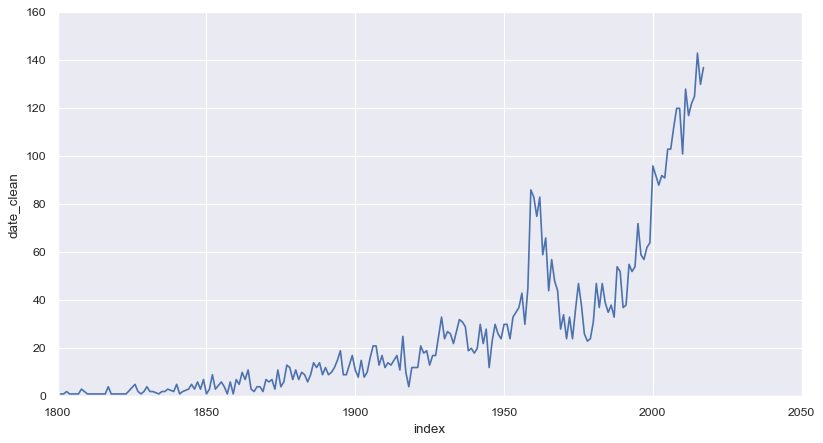

In [103]:
attack_series = pd.DatetimeIndex(df['date_clean']).year.value_counts().sort_index().reset_index()

sns.lineplot(data=attack_series, x="index", y="date_clean");



#### July accumulates most occurences, although splitting cases considering hemispheres seems reasonable.

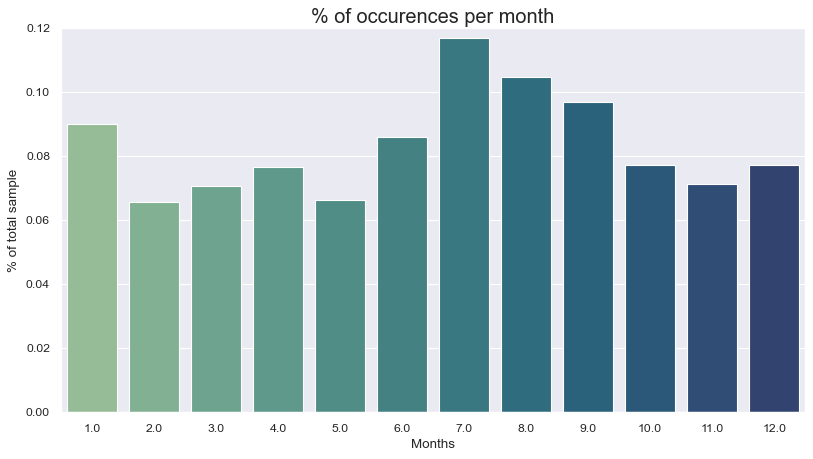

In [104]:
attack_series = pd.DatetimeIndex(df['date_clean']).month.value_counts(normalize=True).sort_index().reset_index()
fig, ax = plt.subplots()
sns.barplot(data=attack_series, x="index", y="date_clean" , palette="crest")
plt.title("% of occurences per month", size=18)
plt.xlabel('Months')
plt.ylabel('% of total sample')
plt.show()




#### Victims are predominantly male, showing a distribution with right skew when analyzing the age of the victims 

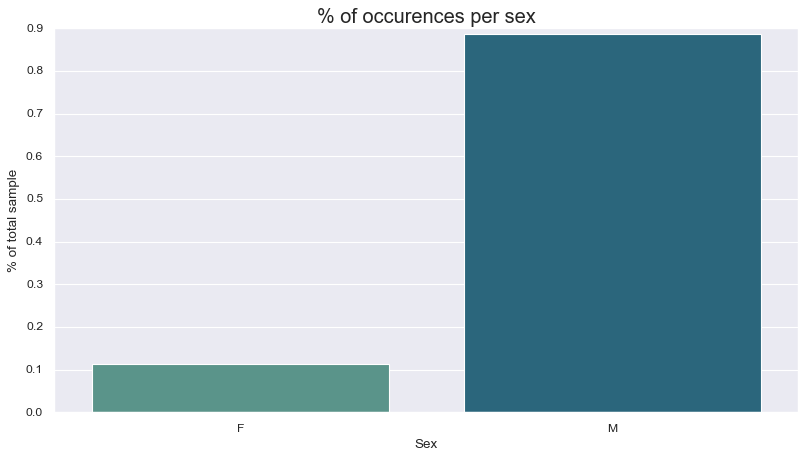

In [105]:
attack_series = df["Sex "].value_counts(normalize=True).sort_index().reset_index()
fig, ax = plt.subplots()
sns.barplot(data=attack_series, x="index", y="Sex " , palette="crest")
plt.title("% of occurences per sex", size=18)
plt.xlabel('Sex')
plt.ylabel('% of total sample')
plt.show()

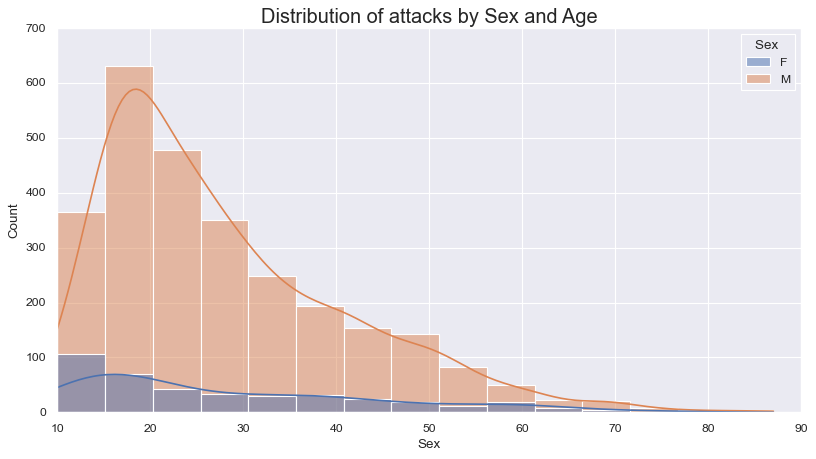

In [106]:
sns.histplot(data=df, x="Age_clean", bins = 15 , hue="Sex ", kde=True)
plt.title("Distribution of attacks by Sex and Age", size=18)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()



#### Attacks with the time mapped happen mostly after 12 AM.

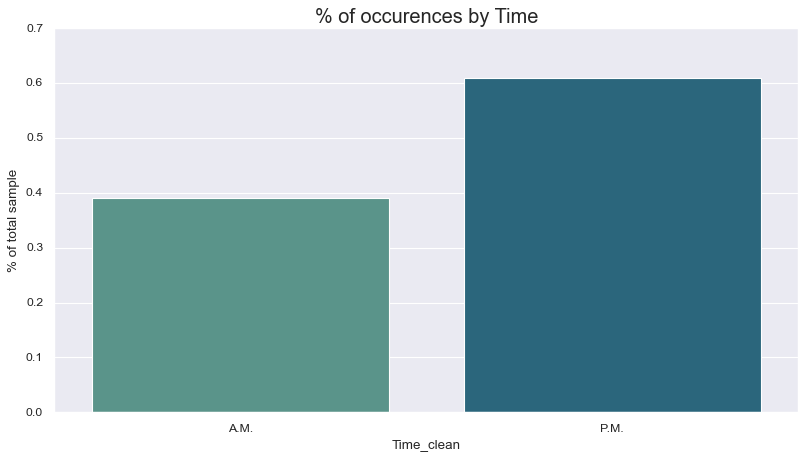

In [107]:
time_day = df["Time_clean"].value_counts(normalize=True).sort_index().reset_index()
fig, ax = plt.subplots()
sns.barplot(data=time_day, x="index", y="Time_clean" , palette="crest")
plt.title("% of occurences by Time", size=18)
plt.xlabel('Time_clean')
plt.ylabel('% of total sample')
plt.show()

## <b>Hypothesis 1:<b> "Provoked attacks have a higher death ratio than unprovoked and, considering there are 20% more attacks after the 12 AM, the time of attack affects the distribution considerably"

###  How much does each type weight over the total count?

- The unprovoked attack type is clearly the predominant type of the sample

In [108]:
df["Type"].value_counts(dropna=False, normalize=True)


Unprovoked      0.724259
Provoked        0.094194
Invalid         0.088230
Boat            0.054201
Sea Disaster    0.038414
NaN             0.000702
Name: Type, dtype: float64

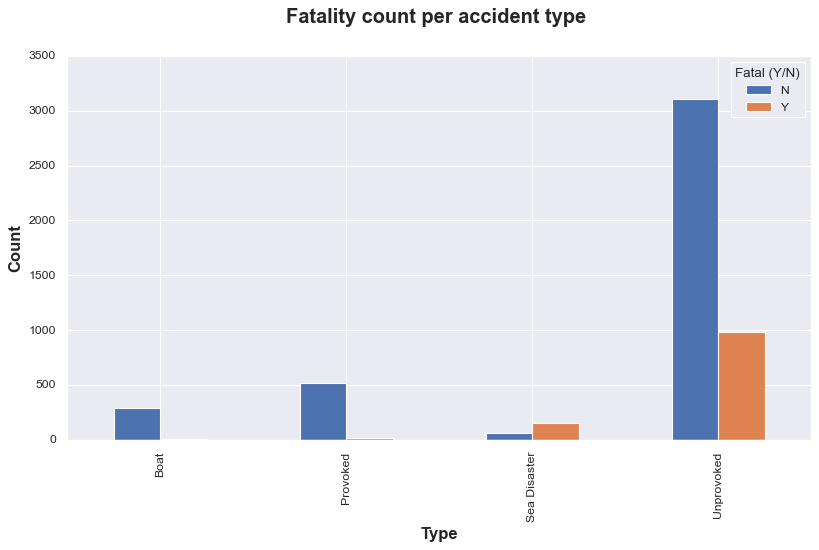

In [109]:
fatal_filt = df[(df["Fatal (Y/N)"]!="UNKNOWN")&(df["Type"]!="Invalid")] # Define sample

(fatal_filt.groupby("Type")["Fatal (Y/N)"].value_counts(normalize=False)
   .unstack("Fatal (Y/N)").plot.bar(stacked=False)
)
plt.title("Fatality count per accident type ", size=18, weight='bold', pad=30)
plt.xlabel('Type', size=15, weight='bold')
plt.ylabel('Count', size=15, weight='bold')
plt.show()

### Are provoked attacks deadlier? Does the time day affect the distribution?

- Considering that the time of the day is representative for 50% of the sample only (50% were not mapped/nulls), i plotted the distribution of all cases, in addition of the ones that occured before or after 12 AM.
- Unprovoked attacks prove to be higher than provoked attacks, proving this hypothesis to be False. Its worth noting that the Sea disaster death ratio is almost 3 times the unprovoked attacks one. Although it can't be proven using this dataset, its reasonable to assume its due to longer exposure to the danger. 
- Other than Sea Disaster, which has %5 more attacks during the afternoon/night relative to the morning, the death rate per attack type does not vary noticeably for most of attack types relative to the time of the attack.

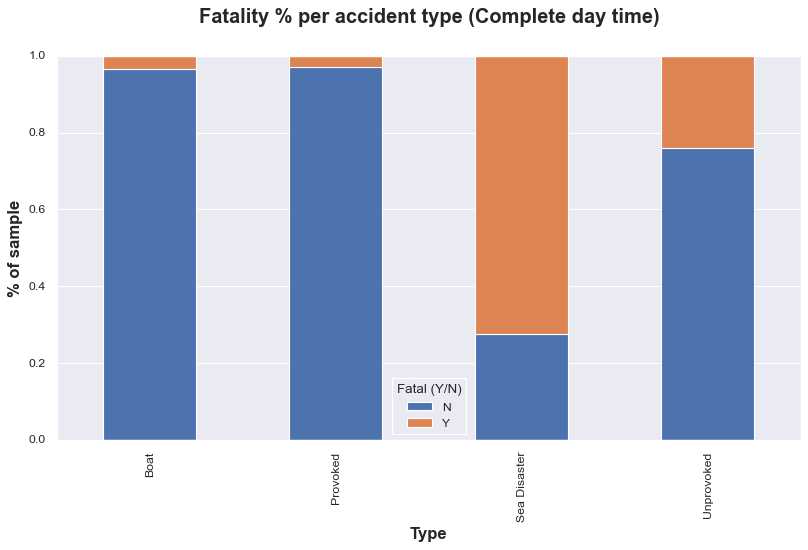

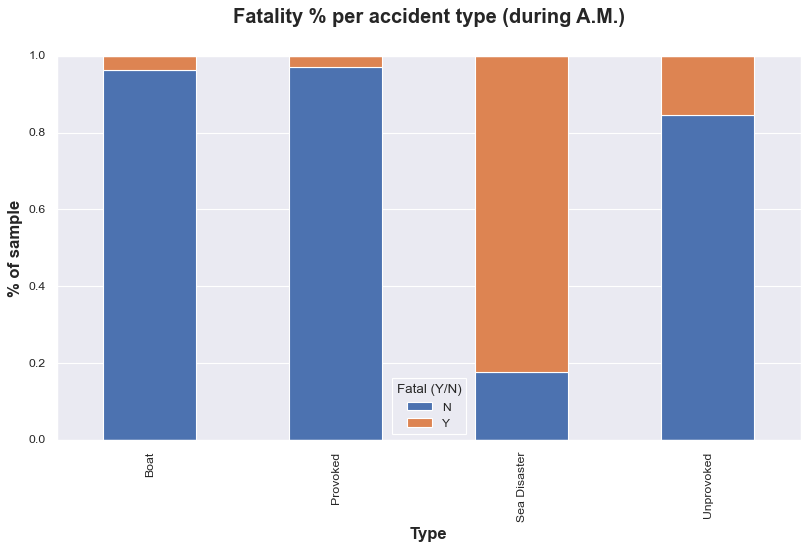

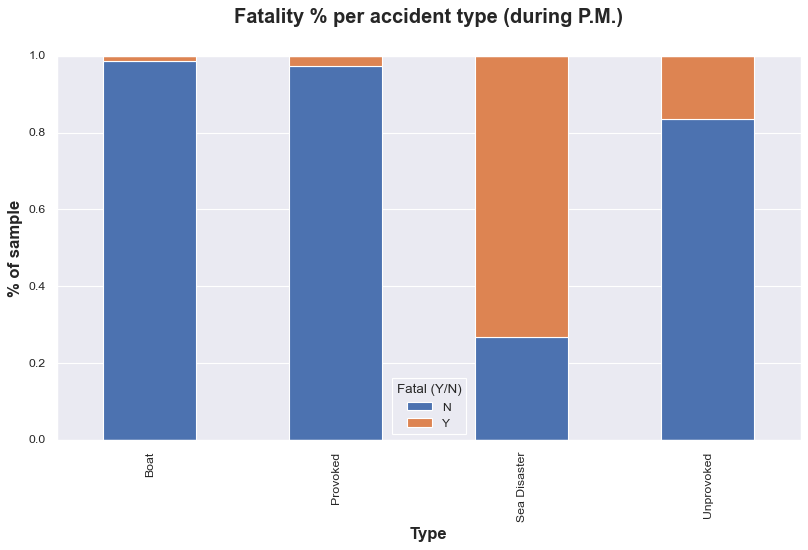

In [110]:

fatal_filt = df[(df["Fatal (Y/N)"]!="UNKNOWN")&(df["Type"]!="Invalid")]
fatal_filt_AM = df[(df["Fatal (Y/N)"]!="UNKNOWN")&(df["Type"]!="Invalid")&(df["Time_clean"]=="A.M.")]
fatal_filt_PM = df[(df["Fatal (Y/N)"]!="UNKNOWN")&(df["Type"]!="Invalid")&(df["Time_clean"]=="P.M.")]



(fatal_filt.groupby("Type")["Fatal (Y/N)"].value_counts(normalize=True)
   .unstack("Fatal (Y/N)").plot.bar(stacked=True)
)
plt.title("Fatality % per accident type (Complete day time)", size=18, weight='bold', pad=30)
plt.xlabel('Type', size=15, weight='bold')
plt.ylabel('% of sample', size=15, weight='bold')
plt.show()

(fatal_filt_AM.groupby("Type")["Fatal (Y/N)"].value_counts(normalize=True)
   .unstack("Fatal (Y/N)").plot.bar(stacked=True)
)
plt.title("Fatality % per accident type (during A.M.)", size=18, weight='bold', pad=30)
plt.xlabel('Type', size=15, weight='bold')
plt.ylabel('% of sample', size=15, weight='bold')
plt.show()

(fatal_filt_PM.groupby("Type")["Fatal (Y/N)"].value_counts(normalize=True)
   .unstack("Fatal (Y/N)").plot.bar(stacked=True)
)
plt.title("Fatality % per accident type (during P.M.)", size=18, weight='bold', pad=30)
plt.xlabel('Type', size=15, weight='bold')
plt.ylabel('% of sample', size=15, weight='bold')
plt.show()



### <b>Result:  False! Unprovoked attacks have a higher death rate, and its distribution is not clearly impacted by the time of the attack

## <b>Hypothesis 2:<b> "The most aggresive specie has the highest kill ratio"

### What are the top 5 most aggressive/most recurring specie identified?

- Grouped unidentified species and species with less than 1% of occurences in the "other/NA" category, which won't be considered for this analysis
- The white shark is the clear winner, doubling the occurences of the tiger shark.

In [111]:
df["Species_clean_2"].value_counts(normalize=True)

other/NA               0.809332
white shark            0.103140
tiger shark            0.041396
bull shark             0.026487
bronze whaler shark    0.010349
blacktip shark         0.009297
Name: Species_clean_2, dtype: float64

### Which top 5 specie is the most deadly?

- Although it could technically be a tie, the Tiger shark is the winner (proving the hypothesis False), with the white shark as the runner up followed closely by the bull shark.
- It is relevant to consider than more that 80% of the shark specie was not specified. It could be possible that the white shark is the easiest to spot, hence the one most identified



In [112]:
top_s = df[(df["Species_clean_2"]!="other/NA")&(df["Fatal (Y/N)"]!="UNKNOWN")]

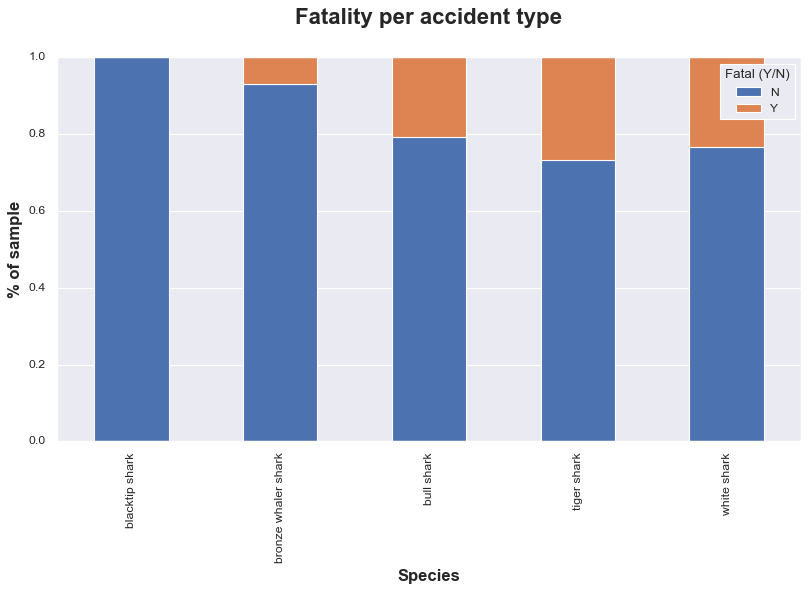

In [113]:
(top_s.groupby("Species_clean_2")["Fatal (Y/N)"].value_counts(normalize=True)
   .unstack("Fatal (Y/N)").plot.bar(stacked=True)
)
plt.title("Fatality per accident type", size=20, weight='bold', pad=30)
plt.xlabel('Species', size=15, weight='bold')
plt.ylabel('% of sample', size=15, weight='bold')
plt.show()

### <b>Result:  False! The white shark (Most aggresive specie) is not the deadliest, according to this sample<b>

## <b>Hypothesis 3:<b> "Attacks happen mostly when the weather is hot, having Swimming and Surfing as the most common activities linked to shark attacks"

### Sampling countries: What are the top 5 Countries? is the % of events relevant?

- Usa, Australia, South Africa, New Zealand and Brazil make the top 5 countries with most shark attacks in the sample.
- This subset makes up 72% of the sampled cases, making it relevant for analysis.

In [114]:
country_rank = df.Country.value_counts(normalize=True, dropna = False).reset_index().head(5)
country_rank

,index,Country
0,usa,0.371163
1,australia,0.219260
2,south africa,0.094720
3,new zealand,0.020874
4,brazil,0.018769


In [115]:
country_rank.Country.sum()

0.7247851254165936

### What are the top 5 Activities? is the % of events relevant?

- Other category: i grouped 17% of Nulls and all activities with a % less than 1%, resulting in category other, 30% of the sample.
- The top 10 mapped activities (not including "other") represent 50%.
- The mix of activities depend on each country, although Swimming and Surfing are the top activities linked to the attacks.
- Its visible that USA and Australia are the countries most affected by shark attacks.

In [116]:
# in Activity_clean_2, i grouped 17% of Nulls and all activities with a % less than 1%, resulting in category other, 30% of the sample.

activity_rank = df.Activity_clean_2.value_counts(normalize=True).reset_index()
activity_rank


,index,Activity_clean_2
0,Other,0.306262
1,surfing,0.171900
2,swimming,0.171023
3,fishing,0.098228
4,spearfishing,0.063848
5,diving,0.033503
6,bathing,0.028942
7,wading,0.027539
8,standing,0.020698
9,scuba diving,0.020172


In [117]:
activity_rank = activity_rank[activity_rank["index"]!="Other"]
activity_rank.Activity_clean_2.head(5).sum()

0.5385020171899666

In [118]:
activity_top5 = list(activity_rank["index"].head(5))
country_top5 = list(country_rank["index"].head(5))

act_coutry_cross_normalized = pd.crosstab(df["Country"][df["Country"].isin(country_top5)], df["Activity_clean_2"][df["Activity_clean_2"].isin(activity_top5)], normalize='index')


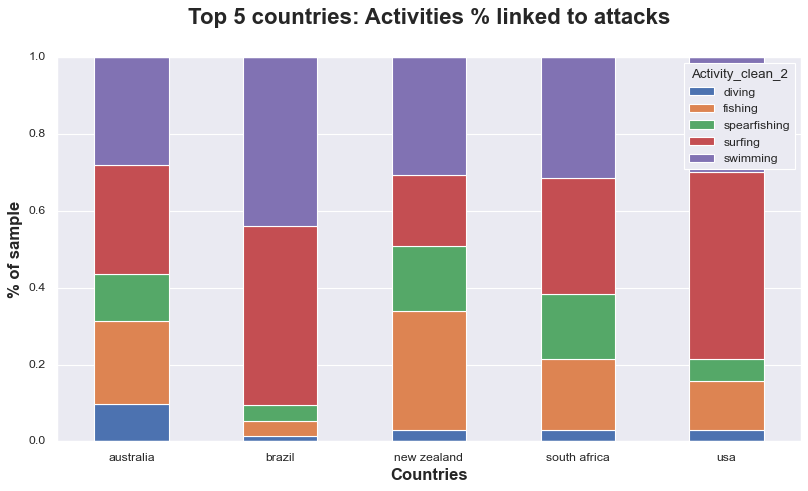

In [119]:
barplot = act_coutry_cross_normalized.plot.bar(stacked= True, rot=0)
plt.title("Top 5 countries: Activities % linked to attacks", size=20, weight='bold', pad=30)
plt.xlabel('Countries', size=15, weight='bold')
plt.ylabel('% of sample', size=15, weight='bold')
plt.show()

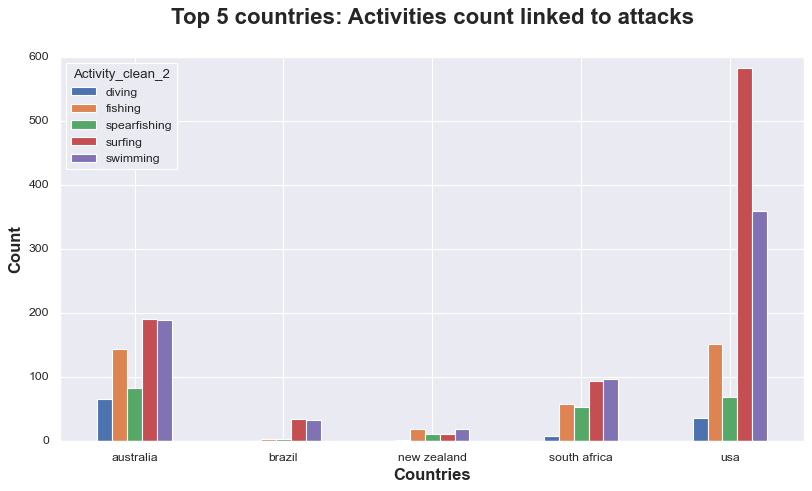

In [120]:
act_coutry_cross = pd.crosstab(df["Country"][df["Country"].isin(country_top5)], df["Activity_clean_2"][df["Activity_clean_2"].isin(activity_top5)])
barplot = act_coutry_cross.plot.bar( rot=0)
plt.title("Top 5 countries: Activities count linked to attacks", size=20, weight='bold', pad=30)
plt.xlabel('Countries', size=15, weight='bold')
plt.ylabel('Count', size=15, weight='bold')
plt.show()

### Do attacks happen mostly when the weather is hot? Is this valid across the top 5 activities?

- After grouping the north and south hemisphere top countries and analyzing the distribution of attacks during the year, its reasonable to say that attacks happen with more frequency during hot months.
- This applies across all activities, We have evidence that supports this hypothesis.

In [121]:
#define a list of countries from the south hemisphere
south_top_countries = list(country_rank["index"].head(5))
south_top_countries.remove("usa")

#Top South hemisfere DF
df_south = df[(df["Country"].isin(south_top_countries))& (df["Activity_clean_2"].isin(activity_top5))]
#Top North hemisfere DF
df_north = df[(df["Country"]=="usa")& (df["Activity_clean_2"].isin(activity_top5))]

C:\Users\Sofia\AppData\Local\Temp\ipykernel_18668\1479089136.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_south[df["Activity_clean_2"]=="swimming"], x=df_south["date_clean"].dt.month, bins = 12 , kde=True)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_18668\1479089136.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_south[df["Activity_clean_2"]=="surfing"], x=df_south["date_clean"].dt.month, bins = 12 , kde=True)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_18668\1479089136.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_south[df["Activity_clean_2"]=="fishing"], x=df_south["date_clean"].dt.month, bins = 12 , kde=True)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_18668\1479089136.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_south[df["Activity_clean_2"]=="spea

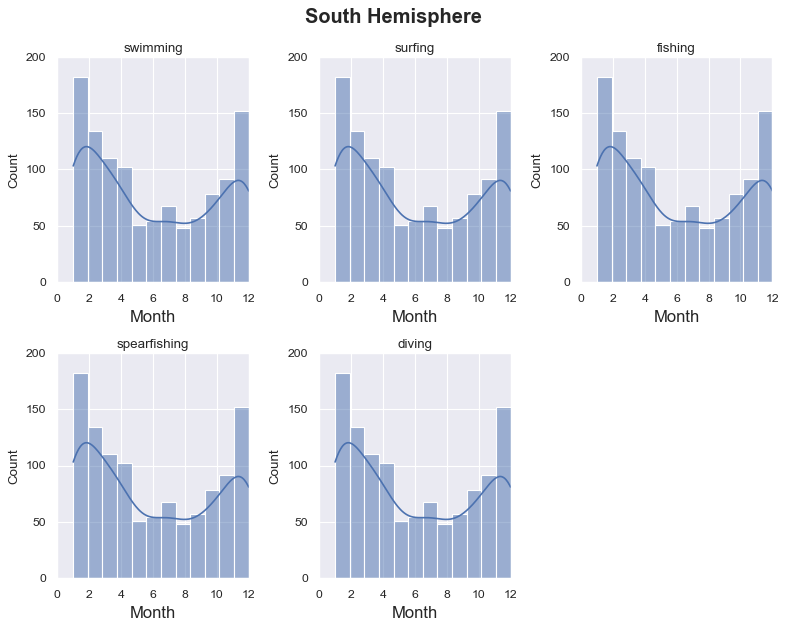

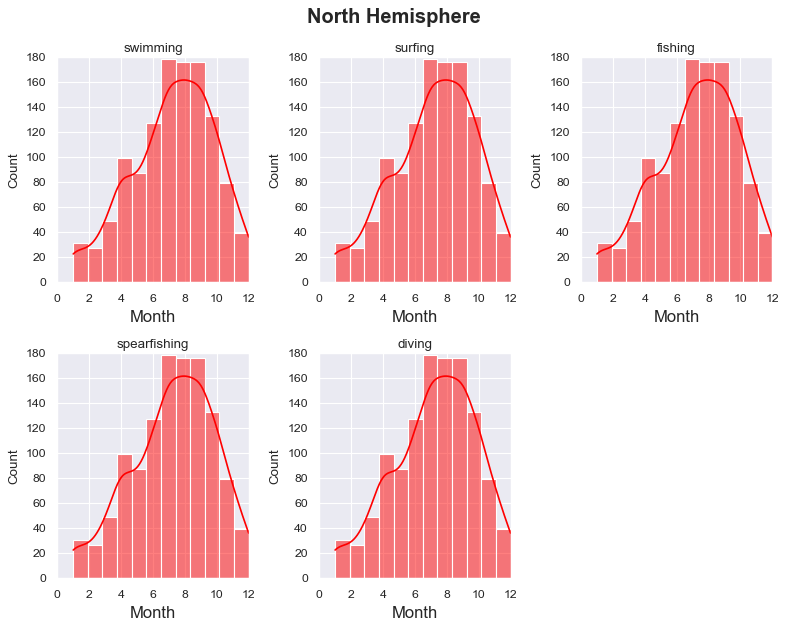

In [122]:

fig = plt.figure(figsize=(10,8))

plt.suptitle("South Hemisphere", size=18, weight= "bold")

#  subplot #1
plt.subplot(231)
plt.title("swimming")
plt.xlabel('Month', size=15)
sns.histplot(data=df_south[df["Activity_clean_2"]=="swimming"], x=df_south["date_clean"].dt.month, bins = 12 , kde=True)

#  subplot #2
plt.subplot(2,3,2)
plt.title("surfing")
plt.xlabel('Month', size=15)
sns.histplot(data=df_south[df["Activity_clean_2"]=="surfing"], x=df_south["date_clean"].dt.month, bins = 12 , kde=True)

#  subplot #3
plt.subplot(233)
plt.title("fishing")
plt.xlabel('Month', size=15)
sns.histplot(data=df_south[df["Activity_clean_2"]=="fishing"], x=df_south["date_clean"].dt.month, bins = 12 , kde=True)

#  subplot #4
plt.subplot(2,3,4)
plt.title("spearfishing")
plt.xlabel('Month', size=15)
sns.histplot(data=df_south[df["Activity_clean_2"]=="spearfishing"], x=df_south["date_clean"].dt.month, bins = 12 , kde=True)

#  subplot #5
plt.subplot(235)
plt.title("diving")
plt.xlabel('Month', size=15)
sns.histplot(data=df_south[df["Activity_clean_2"]=="diving"], x=df_south["date_clean"].dt.month, bins = 12 , kde=True)

plt.tight_layout()
plt.show()

################################################################################
fig = plt.figure(figsize=(10,8))

plt.suptitle("North Hemisphere", size=18, weight= "bold")

#  subplot #1
plt.subplot(231)
plt.title("swimming")
plt.xlabel('Month', size=15)
sns.histplot(data=df_north[df_north["Activity_clean_2"]=="swimming"], x=df_north["date_clean"].dt.month, color= "red",bins = 12 , kde=True)

#  subplot #2
plt.subplot(2,3,2)
plt.title("surfing")
plt.xlabel('Month', size=15)
sns.histplot(data=df_north[df_north["Activity_clean_2"]=="surfing"], x=df_north["date_clean"].dt.month,color= "red", bins = 12 , kde=True)

#  subplot #3
plt.subplot(233)
plt.title("fishing")
plt.xlabel('Month', size=15)
sns.histplot(data=df_north[df_north["Activity_clean_2"]=="fishing"], x=df_north["date_clean"].dt.month,color= "red", bins = 12 , kde=True)

#  subplot #4
plt.subplot(2,3,4)
plt.title("spearfishing")
plt.xlabel('Month', size=15)
sns.histplot(data=df_north[df_north["Activity_clean_2"]=="spearfishing"], x=df_north["date_clean"].dt.month, color= "red", bins = 12 , kde=True)

#  subplot #5
plt.subplot(235)
plt.title("diving")
plt.xlabel('Month', size=15)
sns.histplot(data=df_north[df_north["Activity_clean_2"]=="diving"], x=df_north["date_clean"].dt.month, color= "red", bins = 12 , kde=True)

plt.tight_layout()
plt.show()




### <b>Result:  True! there's evidence that attacks happen mostly during hot months, with surfing and swimming as the main activities behind the attacks<b>